# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Yu"
ln1 = "Xiang"
fn2 = "Jean"
ln2 = "Babin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_xiang_yu_and_babin_jean.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit
from time import time

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

In [3]:
# the usual functions:




def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)

coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

Text(0.5, 1.0, 'Real parameters(coefficients)')

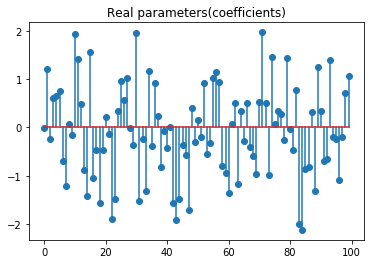

In [5]:
plt.stem(coefs);
plt.title('Real parameters(coefficients)')

In [6]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A,axis=0) ** 2
    # END TODO
    
    r = residuals.copy()
    for t in range(n_iter):
        j = t % n_features
        
        aj_t =  A.T[j,:]  # the j-th column of A
        
        delta_wj = aj_t.dot(r) / (aj_t.dot(aj_t))   # check whether we really need the lipschtiz constant
        w[j] += delta_wj  # update w for the j-th entry
        
        r -= aj_t * delta_wj   # update residual
        
        if t % n_features == 0:
            all_objs.append(np.linalg.norm(r) ** 2 / 2.)
            # all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)  # all the gradient for j = 1, ..., p
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    r = b - A.dot(w)
    # TODO
    lips_const = np.linalg.norm(A,axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
 
        aj_t =  A.T[j,:]  # the j-th column of A
        delta_wj = aj_t.dot(r) / (aj_t.dot(aj_t)) 
        
        # old_w_j =w.copy() 
        w[j] += delta_wj
        r -= aj_t * delta_wj
        # update gradient:
        gradient += gram[:,j] * delta_wj  
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

In [7]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [16]:
#@njit    
def grad_i(i, x, A, b):
    """Gradient with respect to a sample"""  
    return  A.T[i,:]  * (A.dot(x) - b)

#@njit
def grad(x, A, b):
    """Full gradient"""
    return  A.T.dot((A.dot(x) - b))

def loss(x, A, b):
    return norm(A.dot(x) - b) ** 2 / 2 


#### Part 1:  compute a precise minimum with your favorite solver

In [17]:
# choose BFGS as my preferable minimizer
from scipy.optimize import fmin_l_bfgs_b
w_init = np.zeros(n_features)
w_min, f_min, _ = fmin_l_bfgs_b(loss, w_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)

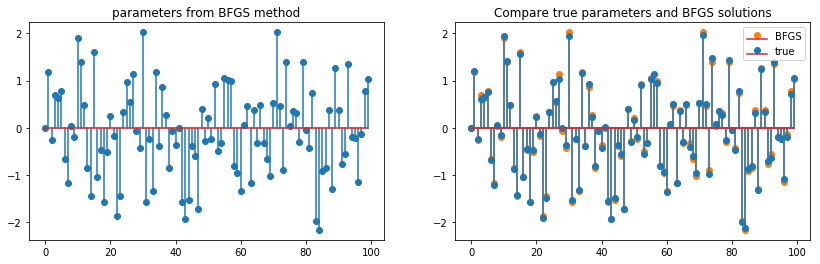

Objective value:  with true parameters: 520.973718778175, with BFGS solutions: 466.3849765337658, BFGS f_min: 466.3849765337658


In [18]:
# show the result of BFGS
plt.figure(figsize=(14., 4.))
plt.subplot(1, 2, 1)
plt.stem(w_min);
plt.title('parameters from BFGS method')

plt.subplot(1, 2, 2)
plt.stem(w_min, label="BFGS", linefmt="C1-", markerfmt="C1o")
plt.stem(coefs, label='true')
plt.title("Compare true parameters and BFGS solutions")
plt.legend(loc=1)
plt.show()

print ("Objective value:  with true parameters: {}, with BFGS solutions: {}, BFGS f_min: {}".format( 
      norm(A.dot(coefs) - b) ** 2 / 2,  norm(A.dot(w_min) - b) ** 2 / 2, f_min))


### Comments:
BFGS solutions better fit the generated $A, b$ than the true parameters 

#### Part 1:  compare the performance of cyclic and greedy CD

In [19]:
n_iter = 500

In [23]:
%timeit w_c, f_c = cyclic_cd(A, b, n_iter)

6.37 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%timeit w_g, f_g = greedy_cd(A, b, n_iter)

12.2 ms ± 602 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
w_c, f_c = cyclic_cd(A, b, n_iter)
w_g, f_g = greedy_cd(A, b, n_iter)

Commment: cyclic_cd takes less time than greed_cd

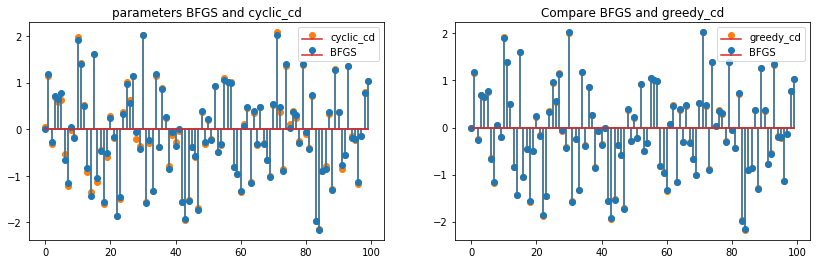

Objective value: BFGS f_min: 466.3849765337658,  cyclic_cd f_min: 687.2379350507928, greedy_cd f_min: 473.8858816069695


In [29]:
plt.figure(figsize=(14., 4.))
plt.subplot(1, 2, 1)
plt.stem(w_c, label="cyclic_cd", linefmt="C1-", markerfmt="C1o")
plt.stem(w_min, label='BFGS')
plt.legend(loc=1)
plt.title('parameters BFGS and cyclic_cd')

plt.subplot(1, 2, 2)
plt.stem(w_g, label="greedy_cd", linefmt="C1-", markerfmt="C1o")
plt.stem(w_min, label='BFGS')
plt.title("Compare BFGS and greedy_cd")
plt.legend(loc=1)
plt.show()

print ("Objective value: BFGS f_min: {},  cyclic_cd f_min: {}, greedy_cd f_min: {}".format( 
       f_min, f_c[-1], f_g[-1]))

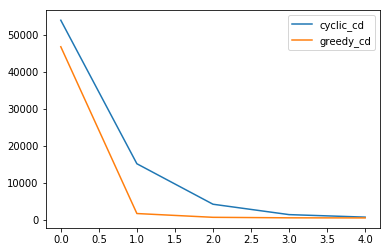

In [30]:
nr_cycle = len(f_c)
plt.plot(np.arange(nr_cycle ), f_c, label="cyclic_cd")
plt.plot(np.arange(nr_cycle ), f_g, label="greedy_cd")
plt.legend(loc=1)
plt.show()

### comment on the performance of cyclic and greedy CD
- greedy CD takes more time to run per iteration than cyclic CD
- greedy CD converges faster by the number of iterations than cyclic CD
- both cyclic CD and greedy CD does well in this case and converges to the optimal solution

This makes sense becasue in the greedy CD, one more step of finding the index of largest gradient is added, and thus slight more time is needed for greedy CD, and therefore greedy CD also have better performance per iteration  

#### Part 1: could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.


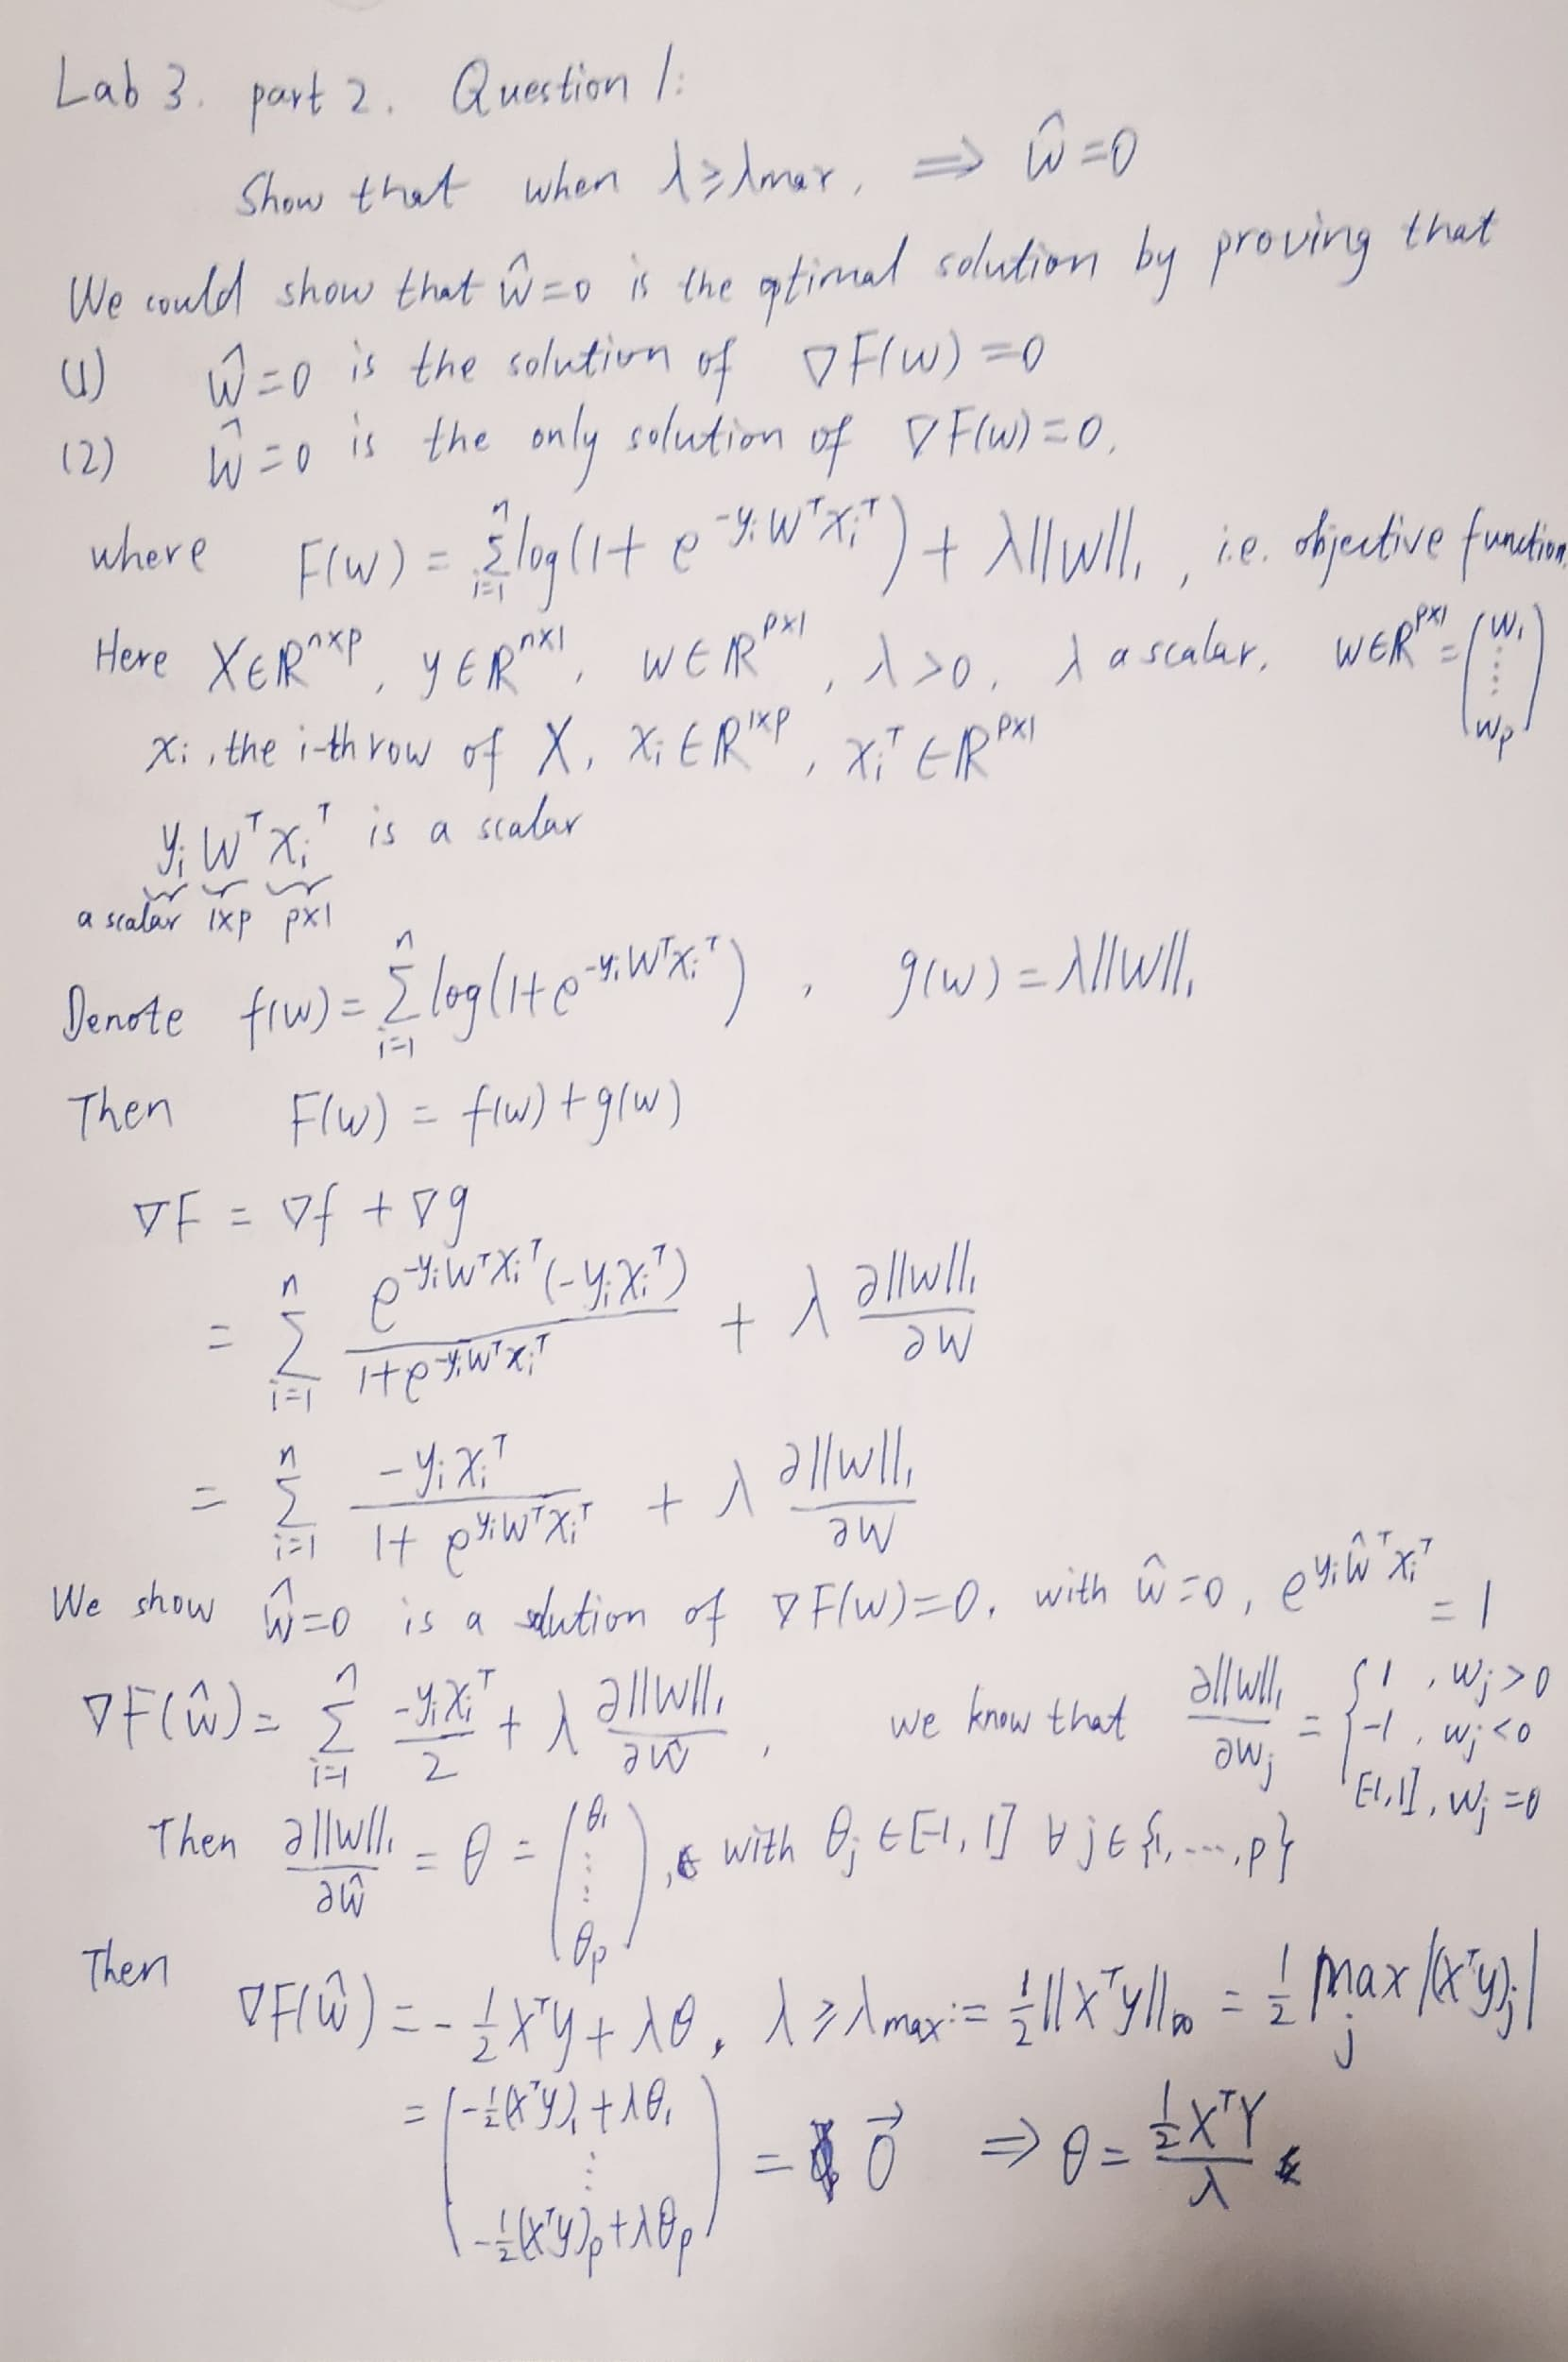

In [32]:
from IPython.display import Image
Image("page1.jpg")

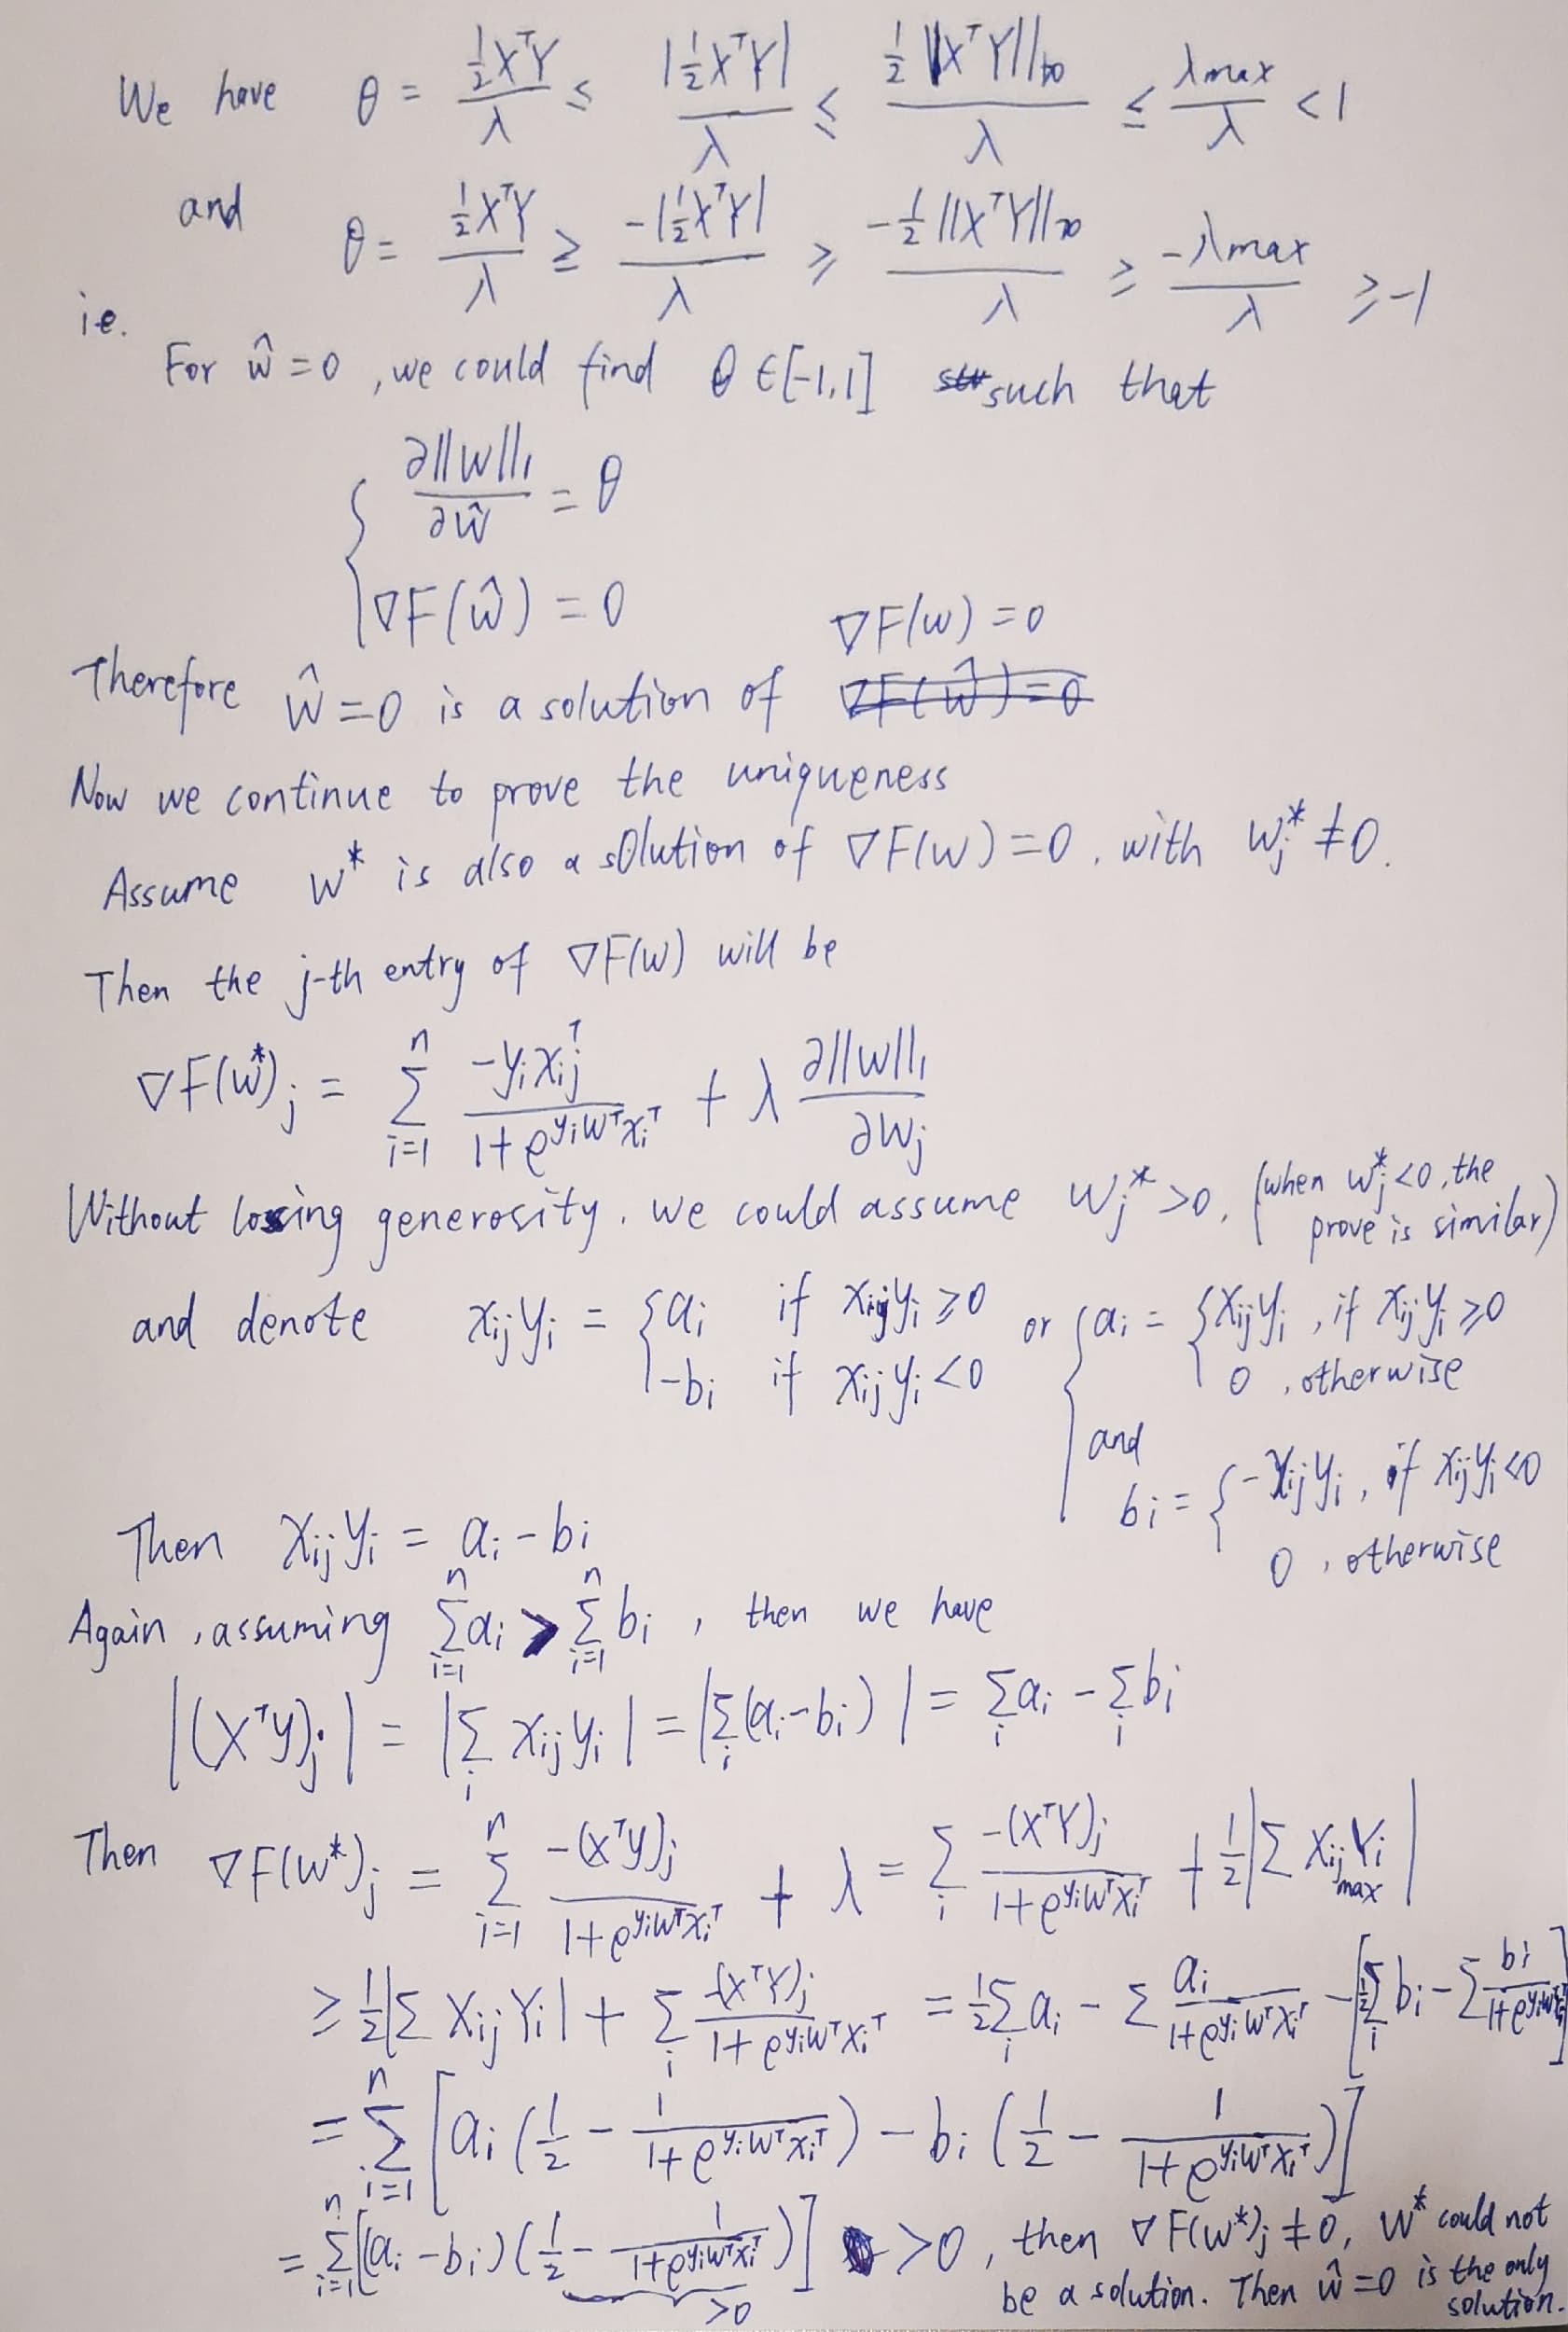

In [33]:
Image("page2.jpg")

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

*answer here*

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$ \large \sum_i  \frac{X_{i, j}^2}{(1 + \mathrm{e}^{-y_i X_{i, j} w_j)^2}}$$
    
**Anwswer**: Becase the updated $w_j$ information is included in each step and therefore the lipschitz constant is more precize and the step size will be adaptive compared to the case $\Vert X_j \Vert^2 / 4$

Implement it in the code with a `better_lc` parameter, and compare.

In [34]:
#@njit
def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

#@njit
def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)

#@njit
def cd_logreg(X, y, lamb, n_iter, lipid=1):
    # lipid to idicate which lipschizt constant to be choose: 
    #     lipid == 1: lipschitz constant:   ∥Xj∥^2 / 4 
    #     lipid == 1: lipschitz constant:   better_lc
      
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w) 
     
    lips_const = np.linalg.norm(X, axis = 0) ** 2 / 4.
    all_obj = []
    
    
    for t in range(n_iter):
        for j in range(n_features):  # cyclic cd 
            old_w_j = w[j]        
            Xj = X[:,j]  # the j-th column of x 
            
            if lipid == 1: 
                step = 1 /  lips_const[j] 
            elif lipid == 2:  # better_lc 
                lips_const_j = np.sum(np.divide(Xj ** 2,   (1 + np.exp(-y * Xj * old_w_j)) ** 2))     
                step  = 1 / lips_const_j
                
            grad_j =  - np.sum(np.multiply(y, Xj) / (1 + np.exp(y * Xw)))
            diff_w_j = old_w_j - step * grad_j
                
            w[j] =  np.sign(diff_w_j) * soft_thresh(diff_w_j, lamb)
            
            if old_w_j != w[j]:
                Xw +=  Xj * (w[j] - old_w_j)
                
        if t % n_features == 0:         
            all_obj.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    
    return w, all_obj

In [35]:
n_iter = 2000
n_samples, n_features = A.shape

# lambd = 1 / n_samples
# w, all_objs = cd_logreg(A, b, lambd, n_iter,lipid=1)
# w_bt_lc, all_objs_bt_lc = cd_logreg(A, b, lambd, n_iter,lipid=2)




# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [421]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_small.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_small.csv', delimiter=',')[1:].T

print(X.shape)
print(y.shape)

(72, 3571)
(72,)


In [80]:
#@njit    
def prox_lasso(w, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(w) * (np.maximum(abs(w)-s,0))

#@njit    
def lasso(w, s):
    """Value of the Lasso penalization at x"""
    return s * norm(w, ord=1)

# #@njit    
# def grad_logreg(w):
#     """Logistic gradient"""
#     # all_obj.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    
#     c = np.exp(-y * X.dot(w))
#     return  np.sum(np.log( 1 + c))


def grad_logreg(w):
    """Logistic gradient"""
    return np.sum(-y * X.T * sigmoid(-y * X.dot(w)), axis = 1)

#@njit    
# def loss_logreg(w):
#     yXw = y * np.dot(X, w)
#     return np.sum(np.log(1. + np.exp(- yXw)))

def loss_logreg(w):
    """Logistic loss"""
    return (np.log(1 + np.exp(-y * X.dot(w)))).sum()

  
def lipschitz_logreg(X):
    return norm(X, ord=2) ** 2 / (4.* n_samples)

In [81]:
#def ista(x0,  f, grad_f, g, prox_g, step, s=0., n_iter=50, x_true=coefs, verbose=True):
#@njit
def ista(x0,  f, grad_f, g, prox_g, step, s=0., n_iter=50):    
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    objectives = []    
    for k in range(n_iter + 1):
        x = prox_g(x - step * grad_f(x), s)       
        obj = f(x) + g(x, s)
        objectives.append(obj)
        
        if k % n_features == 0:
            objectives.append(obj)
        
    return x, objectives 

In [104]:
def prox_lasso(w, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(w) * (np.maximum(abs(w)-s,0))
    
def lasso(w, s):
    """Value of the Lasso penalization at x"""
    return s * norm(w, ord=1)

def grad_logreg(w):
    """Logistic gradient"""
    return np.sum(-y * X.T * sigmoid(-y * X.dot(w)), axis = 1)

def loss_logreg(w):
    """Logistic loss"""
    return (np.log(1 + np.exp(-y * X.dot(w)))).sum()

def lipschitz_logreg():
    return norm(X, ord=2) ** 2 / (4. * n_samples)

def ista(w_init, X, y, lambd, n_iter=50):
    """Proximal gradient descent algorithm
    """
    
    l = lipschitz_logreg()
    step = 1 / l
    
    w = w_init.copy()
    # objective history
    objectives = []
    # Current objective
    obj = loss_logreg(w) + lasso(w, lambd)
    #objectives.append(obj)
        
    for k in range(n_iter + 1):
        
        w = prox_lasso(w - step * grad_logreg(w), lambd / l)
       
        obj = loss_logreg(w) + lasso(w, lambd)
        
        if k % n_features == 0:
            objectives.append(obj)
        #objectives.append(obj)

    return w, objectives

In [93]:
def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b




In [96]:
d = 10
n = 500
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)

In [98]:

f = loss_logreg
grad_f = grad_logreg
g = lasso
prox_g = prox_lasso



X = A 
y = b

step = 1 / lipschitz_logreg(X)

#step = 1 / lipschitz_logreg()


n_samples = X.shape[0]
n_features = X.shape[1]
x_init = np.zeros(n_features)
x_trues = [] 
n_iter = n_features * 10

lambd = 1 /  n_samples ** (0.5)



In [105]:
w_ista, obj_ista = ista(x_init, X, y, lambd, n_iter)
#w_ista, obj_ista = ista(x_init, f, grad_f, g, prox_g, step, lambd, n_iter)

/home/xiang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/xiang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [100]:
w_const_lc, obj_const_lc = cd_logreg(X, y, lambd, n_iter,lipid=1)

In [101]:
w_bt_lc, obj_bt_lc = cd_logreg(X, y, lambd, n_iter,lipid=2)

In [102]:
print (w_ista, w_const_lc, w_bt_lc)

[ 121.34707503  -42.98814033  182.6222903  -103.3161136    74.48091959
 -129.62033793    8.20279305  -82.32695359   71.44471323  -11.53069607] [ 0.7814891  -0.82068585  0.88670206 -0.72271616  0.56513585 -0.54288605
  0.37849433 -0.33063669  0.29792354 -0.28292568] [ 0.56981858 -0.58063185  0.66030157 -0.535634    0.4209034  -0.39216694
  0.28650518 -0.25889538  0.23188898 -0.21680158]


In [106]:
# print (w_ista, w_const_lc, obj_bt_lc)

print ( obj_ista, obj_bt_lc, obj_const_lc)
#print ( obj_ista)

[inf, inf, 8792.354236709176, 5334.209113792698, inf, 5978.253531017938, inf, 6859.684984820385, inf, 7122.349414791281, 7482.7721030994] [177.27364907101148, 152.7968588026434, 160.0509724298125, 161.6205447454405, 161.79565061801645, 161.81323111998026, 161.81497682212824, 161.81514998185682, 161.81516715618764, 161.8151688595563] [177.27364907101145, 149.08661269542728, 150.18886656169067, 150.31896159434007, 150.3328484554335, 150.334312807232, 150.33446701761596, 150.3344832551889, 150.33448496489797, 150.33448514491874]


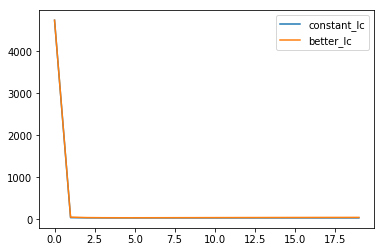

In [76]:
nr_cycle = len(obj_bt_lc)

#plt.plot(np.arange(nr_cycle ), obj_ista, label="constant_lc")
plt.plot(np.arange(nr_cycle ), obj_const_lc, label="constant_lc")
plt.plot(np.arange(nr_cycle ), obj_bt_lc, label="better_lc")
plt.legend(loc=1)
plt.show()

20 [inf, inf, 8792.354236709176, 5334.209113792698, inf, 5978.253531017938, inf, 6859.684984820385, inf, 7122.349414791281, 7482.7721030994]


ValueError: x and y must have same first dimension, but have shapes (20,) and (11,)

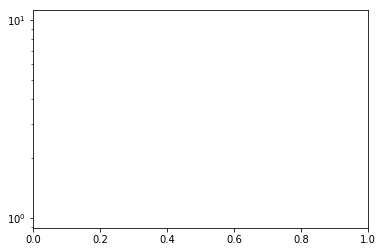

In [107]:
print (nr_cycle ,  obj_ista)

plt.semilogy(np.arange(nr_cycle ), obj_ista, label='Ridge_fista')

Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).